# **Install Library**

In [ ]:
!pip install Sastrawi --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
import nltk
import os
import ast
import matplotlib.pyplot as plt
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('stopwords')

factory = StemmerFactory()
stemmer = factory.create_stemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **MENYIAPKAN DATASET**

In [ ]:
df = pd.read_csv('/content/pintu 2024-2025.csv')
print(df.columns)

Index(['content', 'score', 'at'], dtype='object')


In [ ]:
df.head()

,content,score,at
0,Baik,5,2024-12-31 23:47:25
1,Perbaiki lagi bug nya dan fitur² nya lebih di ...,4,2024-12-31 22:07:08
2,"Kirim usdt 3 hari gak masuk, chat balesnya lam...",1,2024-12-31 17:59:44
3,"App bagus , cuman coin crypto kurg lngkap , ka...",4,2024-12-31 17:46:27
4,Ok,5,2024-12-31 14:33:04


# **PREPROCESSING TEKS**

**1. Case Folding**

In [ ]:
df = pd.read_csv('/content/pintu 2024-2025.csv')

In [ ]:
df['case_folding'] = df['content'].astype(str).str.lower() # Buat kolom baru 'case_folding' dari kolom 'content'
df[['content', 'case_folding']].head() # Tampilkan hasil sebelum dan sesudah case folding untuk contoh 5 data

,content,case_folding
0,Baik,baik
1,Perbaiki lagi bug nya dan fitur² nya lebih di ...,perbaiki lagi bug nya dan fitur² nya lebih di ...
2,"Kirim usdt 3 hari gak masuk, chat balesnya lam...","kirim usdt 3 hari gak masuk, chat balesnya lam..."
3,"App bagus , cuman coin crypto kurg lngkap , ka...","app bagus , cuman coin crypto kurg lngkap , ka..."
4,Ok,ok


In [ ]:
folder_path = 'svm 26 april' # buat path baru
os.makedirs(folder_path, exist_ok=True)
df.to_csv(os.path.join(folder_path, 'hasil casefolding.csv'), index=False)
print("File berhasil disimpan sebagai 'svm 26 april/hasil casefolding.csv'")

File berhasil disimpan sebagai 'svm 26 april/hasil casefolding.csv'


**2. Cleaning**

In [ ]:
df = pd.read_csv('/content/svm 26 april/hasil casefolding.csv') # Load dataset hasil case folding

def clean_text(text): # Fungsi cleaning
    text = str(text).lower()  # Lowercase
    text = re.sub(r'(?<=[\w])([.,!?;:])(?=[\w])', r' \1 ', text) # Tambahkan spasi jika simbol seperti titik, koma, tanda seru menempel di antara huruf
    text = re.sub(r'\.{2,}', ' ', text)                  # Ganti dua titik atau lebih dengan spasi
    text = re.sub(r'[-_]', ' ', text)                    # Ganti - dan _ dengan spasi
    text = re.sub(r'http\S+|www.\S+', ' ', text)         # Hapus URL
    text = re.sub(r'<.*?>', ' ', text)                   # Hapus tag HTML
    text = re.sub(r'@\w+', ' ', text)                    # Hapus mention
    text = re.sub(r'#\S+', '', text)                     # Ambil kata dari hashtag
    text = re.sub(r'\d+', ' ', text)                     # Hapus angka
    text = re.sub(r'[²³¹⁰⁴⁵⁶⁷⁸⁹⁺⁻⁼]', ' ', text)         # Hapus karakter superscript
    text = re.sub(r'[\(\)\[\]]', ' ', text)              # Hapus tanda kurung dan ganti dengan spasi
    text = re.sub(
        r'[^\w\s\u263a-\u263c\u2600-\u26FF\u2700-\u27BF\U0001F300-\U0001FAFF]',
        ' ', text)                                       # Hapus simbol non-emoji (kecuali huruf, angka, dan emoji unicode)
    text = re.sub(r'\s+', ' ', text).strip()             # Rapikan spasi
    return text

df['cleaned'] = df['case_folding'].apply(clean_text) # Tambahkan fungsi ke kolom 'case_folding'
print("Contoh hasil cleaning:")
print(df[['case_folding', 'cleaned']].head())

Contoh hasil cleaning:
                                        case_folding  \
0                                               baik   
1  perbaiki lagi bug nya dan fitur² nya lebih di ...   
2  kirim usdt 3 hari gak masuk, chat balesnya lam...   
3  app bagus , cuman coin crypto kurg lngkap , ka...   
4                                                 ok   

                                             cleaned  
0                                               baik  
1  perbaiki lagi bug nya dan fitur nya lebih di t...  
2  kirim usdt hari gak masuk chat balesnya lama d...  
3  app bagus cuman coin crypto kurg lngkap kalo b...  
4                                                 ok  


In [ ]:
df.to_csv('svm 26 april/hasil cleaned.csv', index=False)
print("✅ File berhasil disimpan sebagai 'hasil cleaned.csv'")

✅ File berhasil disimpan sebagai 'hasil cleaned.csv'


**3. Normalization**

In [ ]:
df = pd.read_csv('/content/svm 26 april/hasil cleaned.csv')
kamus = pd.read_csv('/content/kamus custom normalisasi.csv')

kamus.dropna(subset=['slang', 'formal'], inplace=True) # Hapus baris NaN dan urutkan berdasarkan jumlah kata slang (untuk prioritas bigram)
kamus['slang'] = kamus['slang'].str.lower()
kamus['formal'] = kamus['formal'].str.lower()
kamus['jumlah_kata'] = kamus['slang'].str.count(' ') + 1
kamus_sorted = kamus.sort_values(by='jumlah_kata', ascending=False)  # bigram dulu baru unigram

compiled_patterns = [ # Compile semua pola regex dari kamus
    (re.compile(r'\b' + re.escape(slang) + r'\b'), formal)
    for slang, formal in zip(kamus_sorted['slang'], kamus_sorted['formal'])
]

def normalize_text(text): # Fungsi normalisasi untuk string kalimat
    if pd.isnull(text):
        return ""
    text = text.lower()
    for pattern, formal in compiled_patterns:
        text = pattern.sub(formal, text)
    return text

df['normalisasi'] = df['cleaned'].apply(normalize_text)
print("Contoh hasil normalisasi (tanpa tokenisasi):")
print(df[['cleaned', 'normalisasi']].head())

Contoh hasil normalisasi (tanpa tokenisasi):
                                             cleaned  \
0                                               baik   
1  perbaiki lagi bug nya dan fitur nya lebih di t...   
2  kirim usdt hari gak masuk chat balesnya lama d...   
3  app bagus cuman coin crypto kurg lngkap kalo b...   
4                                                 ok   

                                         normalisasi  
0                                               baik  
1  diperbaiki lagi bug nya dan fitur nya lebih di...  
2  kirim usdt hari tidak masuk chat balasan lama ...  
3  aplikasi bagus cuma coin crypto kurang lengkap...  
4                                                 ok  


In [ ]:
df.to_csv('svm 26 april/hasil normalisasi.csv', index=False)
print("✅ Tokenisasi selesai dan file disimpan sebagai 'hasil normalisasi.csv'")

✅ Tokenisasi selesai dan file disimpan sebagai 'hasil normalisasi.csv'


In [ ]:
df = pd.read_csv('/content/svm 26 april/hasil normalisasi.csv')
df = df.drop_duplicates(subset='normalisasi', keep='first').reset_index(drop=True) # Hapus duplikasi berdasarkan kolom 'normalisasi'
print(f"Jumlah data setelah hapus duplikasi: {len(df)}")
print(df[['normalisasi']].head())

df.to_csv('/content/svm 26 april/hapus duplikasi data.csv', index=False) # Simpan hasil untuk mengecek apakah sudah ulasan yang duplikat sudah dihapus

Jumlah data setelah hapus duplikasi: 6862
                                         normalisasi
0                                               baik
1  diperbaiki lagi bug nya dan fitur nya lebih di...
2  kirim usdt hari tidak masuk chat balasan lama ...
3  aplikasi bagus cuma coin crypto kurang lengkap...
4                                                 ok


**4. Tokenization**

In [ ]:
df = pd.read_csv('/content/svm 26 april/hapus duplikasi data.csv')

def tokenize(text): # Fungsi tokenisasi
    text = str(text)
    pattern = r"""
        (?:[\U0001F600-\U0001F64F])        |  # Emoticons
        (?:[\U0001F300-\U0001F5FF])        |  # Symbols & Pictographs
        (?:[\U0001F680-\U0001F6FF])        |  # Transport & Map
        (?:[\U0001F1E0-\U0001F1FF])        |  # Flags
        \w+(?:-\w+)*                       |  # Kata biasa dan kata dengan tanda hubung
        [^\s\w]                               # Simbol lain yang tidak termasuk huruf/angka/spasi
    """

    tokens = re.findall(pattern, text, flags=re.VERBOSE)
    return tokens

# Menerapkan tokenisasi ke kolom 'normalisasi'
df['tokens'] = df['normalisasi'].apply(tokenize)

print("Contoh hasil tokenisasi:")
print(df[['normalisasi', 'tokens']].head())

Contoh hasil tokenisasi:
                                         normalisasi  \
0                                               baik   
1  diperbaiki lagi bug nya dan fitur nya lebih di...   
2  kirim usdt hari tidak masuk chat balasan lama ...   
3  aplikasi bagus cuma coin crypto kurang lengkap...   
4                                                 ok   

                                              tokens  
0                                             [baik]  
1  [diperbaiki, lagi, bug, nya, dan, fitur, nya, ...  
2  [kirim, usdt, hari, tidak, masuk, chat, balasa...  
3  [aplikasi, bagus, cuma, coin, crypto, kurang, ...  
4                                               [ok]  


In [ ]:
df.to_csv('svm 26 april/hasil tokenized.csv', index=False)
print("✅ Tokenisasi selesai dan file disimpan sebagai 'hasil tokenized.csv'")

✅ Tokenisasi selesai dan file disimpan sebagai 'hasil tokenized.csv'


**5. STOPWORDS REMOVAL**

In [ ]:
df = pd.read_csv('/content/svm 26 april/hasil tokenized.csv')
kamus_negasi = pd.read_csv('/content/kamus kata negasi.csv')
stopwords_df = pd.read_csv('/content/kamus pintu stopwords.csv')

negasi_phrases = kamus_negasi['negasi'].dropna().str.lower().tolist()
negasi_phrases = sorted(negasi_phrases, key=lambda x: len(x.split()), reverse=True)

csv_stopwords = stopwords_df[stopwords_df['hapus'] == 1]['token'].str.lower().tolist()
nltk_sw = nltk_stopwords.words('english')
combined_stopwords = set(csv_stopwords + nltk_sw)

# Fungsi gabungan: proses negasi dan hapus stopwords
def proses_negasi_dan_stopwords(tokens):
    if isinstance(tokens, str):
        try:
            tokens = ast.literal_eval(tokens)
        except:
            return tokens

    if not isinstance(tokens, list):
        return tokens

    tokens = [t.lower() for t in tokens]
    output = tokens[:]
    i = 0
    while i < len(tokens):
        match_found = False
        for phrase in negasi_phrases:
            phrase_tokens = phrase.split()
            n = len(phrase_tokens)
            if tokens[i:i+n] == phrase_tokens:
                index = i + n
                # Cari token setelah negasi yang BUKAN stopwords
                while index < len(tokens) and tokens[index] in combined_stopwords:
                    index += 1
                if index < len(tokens):
                    if not output[index].startswith("NEG_"):
                        output[index] = "NEG_" + output[index]
                i += n
                match_found = True
                break
        if not match_found:
            i += 1

    # Hapus semua stopwords, kecuali token yang dimulai dengan NEG_
    hasil_bersih = [
        t for t in output
        if isinstance(t, str) and t.strip() and (t not in combined_stopwords or t.startswith("NEG_"))
    ]
    return hasil_bersih

# Terapkan ke dataframe
df['stopwords'] = df['tokens'].apply(proses_negasi_dan_stopwords)

# Cek hasil
print(df[['tokens', 'stopwords']].head())

                                              tokens  \
0                                           ['baik']   
1  ['diperbaiki', 'lagi', 'bug', 'nya', 'dan', 'f...   
2  ['kirim', 'usdt', 'hari', 'tidak', 'masuk', 'c...   
3  ['aplikasi', 'bagus', 'cuma', 'coin', 'crypto'...   
4                                             ['ok']   

                                           stopwords  
0                                                 []  
1  [diperbaiki, bug, fitur, tingkatkan, ditambah,...  
2  [kirim, usdt, NEG_chat, balasan, lama, persuli...  
3  [aplikasi, bagus, cuma, coin, crypto, NEG_leng...  
4                                                 []  


In [ ]:
df.to_csv('svm 26 april/hasil stopwords.csv', index=False)
print("✅ Tokenisasi selesai dan file disimpan sebagai 'hasil stopwords.csv'")

✅ Tokenisasi selesai dan file disimpan sebagai 'hasil stopwords.csv'


**6. STEMMING**

In [ ]:
df = pd.read_csv('/content/svm 26 april/hasil stopwords.csv', encoding='utf-8')

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def is_emoji(token):
    return bool(re.match(
        r'^[\U0001F600-\U0001F64F'
        r'\U0001F300-\U0001F5FF'
        r'\U0001F680-\U0001F6FF'
        r'\U0001F1E0-\U0001F1FF'
        r'\u2600-\u26FF'
        r'\u2700-\u27BF'
        r']+$', token))

# Fungsi stemming
def stem_tokens(tokens):
    if isinstance(tokens, str):
        tokens = ast.literal_eval(tokens)
    stemmed_tokens = []
    for token in tokens:
        if token.startswith("NEG_"):
            original = token[4:]
            if is_emoji(original):
                stemmed_tokens.append("NEG_")
                stemmed_tokens.append(original)
            else:
                stemmed = stemmer.stem(original)
                stemmed_tokens.append("NEG_" + stemmed)
        elif is_emoji(token):
            stemmed_tokens.append(token)
        else:
            stemmed_tokens.append(stemmer.stem(token))
    return stemmed_tokens

df['stemming'] = df['stopwords'].apply(stem_tokens)
df['stemming_text'] = df['stemming'].apply(lambda tokens: ' '.join(tokens))

print("Contoh hasil stemming:")
print(df[['stemming', 'stemming_text']].head())

df.to_csv('/content/svm 26 april/hasil stemming.csv', index=False)
print("✅ Proses stemming selesai. File disimpan sebagai 'hasil stemming.csv'")

Contoh hasil stemming:
                                            stemming  \
0                                                 []   
1  [baik, bug, fitur, tingkat, tambah, stop, limi...   
2  [kirim, usdt, NEG_chat, balas, lama, sulit, NE...   
3  [aplikasi, bagus, cuma, coin, crypto, NEG_leng...   
4                                                 []   

                                       stemming_text  
0                                                     
1  baik bug fitur tingkat tambah stop limit order...  
2  kirim usdt NEG_chat balas lama sulit NEG_beli ...  
3  aplikasi bagus cuma coin crypto NEG_lengkap fo...  
4                                                     
✅ Proses stemming selesai. File disimpan sebagai 'hasil stemming.csv'


In [ ]:
# ambil kolom stemming_text dan score

df = pd.read_csv('/content/svm 26 april/hasil stemming.csv')
df_selected = df[['stemming_text', 'score']]
df_selected.to_csv('/content/svm 26 april/sentimen belum pelabelan.csv', index=False)
print("✅ File berhasil disimpan sebagai 'sentimen belum pelabelan.csv'")

✅ File berhasil disimpan sebagai 'sentimen belum pelabelan.csv'


# **PELABELAN DATA**

In [ ]:
lexicon_pintu = pd.read_csv('kamus lexicon pintu.csv')
unigram_dict = dict(zip(lexicon_pintu['token'], lexicon_pintu['sentiment']))

kamus_emoji = pd.read_csv('daftar emoji.csv')
emoji_dict = dict(zip(kamus_emoji['emoji'], kamus_emoji['sentiment']))

df = pd.read_csv('/content/svm 26 april/sentimen belum pelabelan.csv')
df = df.dropna(subset=['stemming_text'])

# Pola emoji
emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"
    u"\U0001F300-\U0001F5FF"
    u"\U0001F680-\U0001F6FF"
    u"\U0001F1E0-\U0001F1FF"
    u"\u2600-\u26FF"
    u"\u2700-\u27BF"
    "]+", flags=re.UNICODE)

# Fungsi pelabelan dengan bobot
def label_sentimen(row):
    text = row['stemming_text']
    tokens = text.split()
    nilai_token = 0

    # Skor token
    for token in tokens:
        if token in unigram_dict:
            nilai_token += unigram_dict[token]

    # Skor emoji
    emojis = emoji_pattern.findall(text)
    for emo in emojis:
        if emo in emoji_dict and pd.notna(emoji_dict[emo]):
            nilai_token += emoji_dict[emo]

    # Skor rating
    nilai_rating = 0
    if 'score' in row and pd.notna(row['score']):
        try:
            rating = int(row['score'])
            if rating == 5:
                nilai_rating = 2
            elif rating == 4:
                nilai_rating = 1
            elif rating == 3:
                nilai_rating = 0
            elif rating == 2:
                nilai_rating = -1
            elif rating == 1:
                nilai_rating = -2
        except:
            pass

    # Gabungan skor dengan bobot 30% ulasan, 70% rating
    jumlah_nilai = round((0.3 * nilai_token) + (0.7 * nilai_rating), 2)
    row['jumlah_nilai'] = jumlah_nilai

    # Penentuan label
    if -0.3 <= jumlah_nilai <= 0.3:
      row['label_sentimen'] = 'Netral'
    elif jumlah_nilai < -0.3:
      row['label_sentimen'] = 'Negatif'
    else:
      row['label_sentimen'] = 'Positif'

    return row

df = df.apply(label_sentimen, axis=1)
df.to_csv('/content/svm 26 april/hasil pelabelan.csv', index=False)
print("✅ File berhasil disimpan sebagai hasil pelabelan.csv")

print(df[['stemming_text', 'score', 'jumlah_nilai', 'label_sentimen']].head())

✅ File berhasil disimpan sebagai hasil pelabelan.csv
                                       stemming_text  score  jumlah_nilai  \
1  baik bug fitur tingkat tambah stop limit order...      4           0.1   
2  kirim usdt NEG_chat balas lama sulit NEG_beli ...      1          -2.0   
3  aplikasi bagus cuma coin crypto NEG_lengkap fo...      4           1.3   
5                                       mantap pintu      5           1.7   
6                      aplikasi direkomedasikan mula      5           1.7   

  label_sentimen  
1         Netral  
2        Negatif  
3        Positif  
5        Positif  
6        Positif  


# **PEMBOBOTAN TF-IDF**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.read_csv('/content/svm 26 april/hasil pelabelan.csv')

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['stemming_text'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
term_avg_weights = tfidf_df.mean(axis=0).sort_values(ascending=False).reset_index()
term_avg_weights.columns = ['term', 'weight']

term_avg_weights.to_csv('/content/svm 26 april/pembobotan kata tf-idf.csv', index=False)
print("Hasil TF-IDF disimpan sebagai tfidf_term_weights.csv")

Hasil TF-IDF disimpan sebagai tfidf_term_weights.csv



# **PEMBAGIAN DATA**

In [ ]:
# Split 70:30
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler

df = pd.read_csv('/content/svm 26 april/hasil pelabelan.csv')

X = df['stemming_text']
y = df['label_sentimen']

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X)

# Atasi ketidakseimbangan data
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_tfidf, y)

# Split data: train 70%, test 30%
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)

# Inisialisasi dan latih model SVM dengan penyeimbangan kelas
svm_model = LinearSVC(class_weight={'Negatif':1.0, 'Netral':1.0, 'Positif':1.3})
svm_model.fit(X_train, y_train)

# Prediksi data uji
y_pred = svm_model.predict(X_test)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("Hasil Evaluasi SVM (Dengan Oversampling dan class_weight):")
print(f"Akurasi   : {accuracy:.4f}")
print(f"Presisi   : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-Score  : {f1:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Hasil Evaluasi SVM (Dengan Oversampling dan class_weight):
Akurasi   : 0.9242
Presisi   : 0.9256
Recall    : 0.9242
F1-Score  : 0.9243

📋 Classification Report:
              precision    recall  f1-score   support

     Negatif       0.93      0.91      0.92      1530
      Netral       0.89      0.95      0.92      1530
     Positif       0.96      0.91      0.93      1531

    accuracy                           0.92      4591
   macro avg       0.93      0.92      0.92      4591
weighted avg       0.93      0.92      0.92      4591



In [ ]:
# Prediksi data latih (train)
y_train_pred = svm_model.predict(X_train)

# Evaluasi model di data latih
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted', zero_division=0)
recall_train = recall_score(y_train, y_train_pred, average='weighted', zero_division=0)
f1_train = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)

print("\n📊 Evaluasi di Data Train:")
print(f"Akurasi   : {accuracy_train:.4f}")
print(f"Presisi   : {precision_train:.4f}")
print(f"Recall    : {recall_train:.4f}")
print(f"F1-Score  : {f1_train:.4f}")

print("\n📋 Classification Report (Train):")
print(classification_report(y_train, y_train_pred, zero_division=0))


📊 Evaluasi di Data Train:
Akurasi   : 0.9405
Presisi   : 0.9411
Recall    : 0.9405
F1-Score  : 0.9406

📋 Classification Report (Train):
              precision    recall  f1-score   support

     Negatif       0.95      0.92      0.94      3571
      Netral       0.91      0.95      0.93      3571
     Positif       0.96      0.95      0.96      3570

    accuracy                           0.94     10712
   macro avg       0.94      0.94      0.94     10712
weighted avg       0.94      0.94      0.94     10712



# **Confusion Matrix**

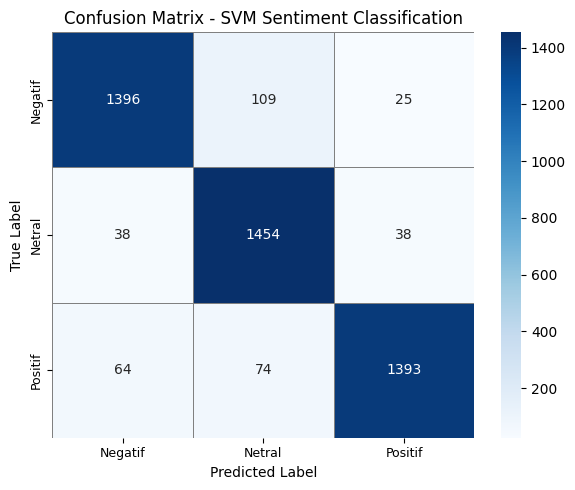

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Label urutan tetap
labels = ['Negatif', 'Netral', 'Positif']

# Buat confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Konversi ke DataFrame agar mudah dibaca
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plot heatmap confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='gray')
plt.title('Confusion Matrix - SVM Sentiment Classification', fontsize=12)
plt.xlabel('Predicted Label', fontsize=10)
plt.ylabel('True Label', fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

# **Visualisasi**

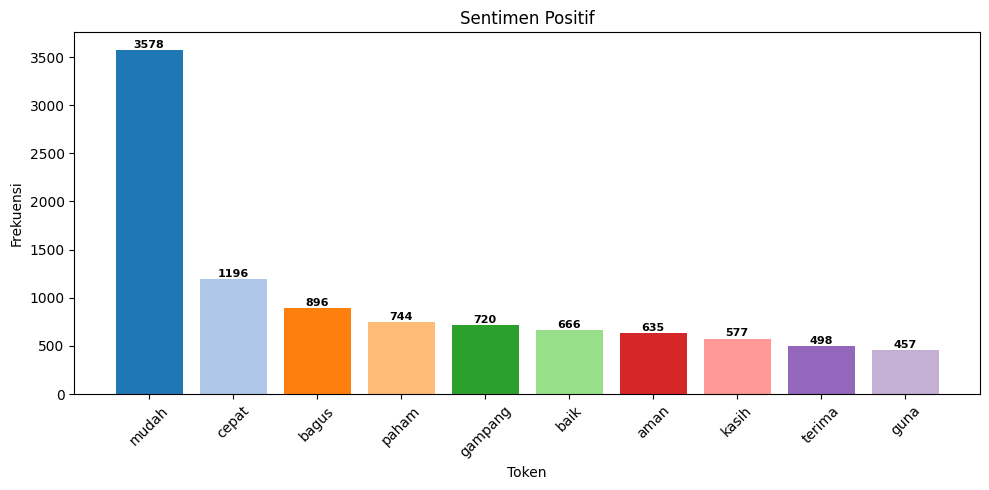

In [ ]:
# Sentimem kata positif
import matplotlib.pyplot as plt
from collections import Counter

df = pd.read_csv('/content/svm 26 april/hasil pelabelan.csv')
lexicon = pd.read_csv('kamus lexicon pintu.csv')
lexicon_dict = dict(zip(lexicon['token'], lexicon['sentiment']))

# Hitung frekuensi token yang ada di stemming_text
token_counter = Counter()
for row in df['stemming_text'].dropna():
    tokens = row.split()
    for token in tokens:
        token_counter[token] += 1

# Kelompokkan token ke dalam kategori sentimen dari lexicon
pos_tokens = {}
neg_tokens = {}
netral_tokens = {}

for token, freq in token_counter.items():
    if token in lexicon_dict:
        score = lexicon_dict[token]
        if score > 0:
            pos_tokens[token] = freq
        elif score < 0:
            neg_tokens[token] = freq
        else:
            netral_tokens[token] = freq

# Ambil 10 token dengan frekuensi tertinggi dari masing-masing sentimen
top_pos = dict(Counter(pos_tokens).most_common(10))

# Fungsi untuk membuat warna acak
def get_random_colors(n):
    colors = plt.cm.tab20.colors  # palet warna yang bervariasi
    return [colors[i % len(colors)] for i in range(n)]

# Fungsi visualisasi diagram batang berwarna-warni dengan label angka
def plot_bar(data_dict, title):
    tokens = list(data_dict.keys())
    freqs = list(data_dict.values())
    colors = get_random_colors(len(tokens))

    plt.figure(figsize=(10, 5))
    bars = plt.bar(tokens, freqs, color=colors)
    plt.title(f'Sentimen {title}')
    plt.xlabel('Token')
    plt.ylabel('Frekuensi')
    plt.xticks(rotation=45)

    # Tambahkan label angka di atas setiap batang
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.5,
            str(int(height)),
            ha='center',
            va='bottom',
            fontsize=8,
            fontweight='semibold',
            color='#030303'
        )

    plt.tight_layout()
    plt.show()

# Panggil fungsi
plot_bar(top_pos, 'Positif')

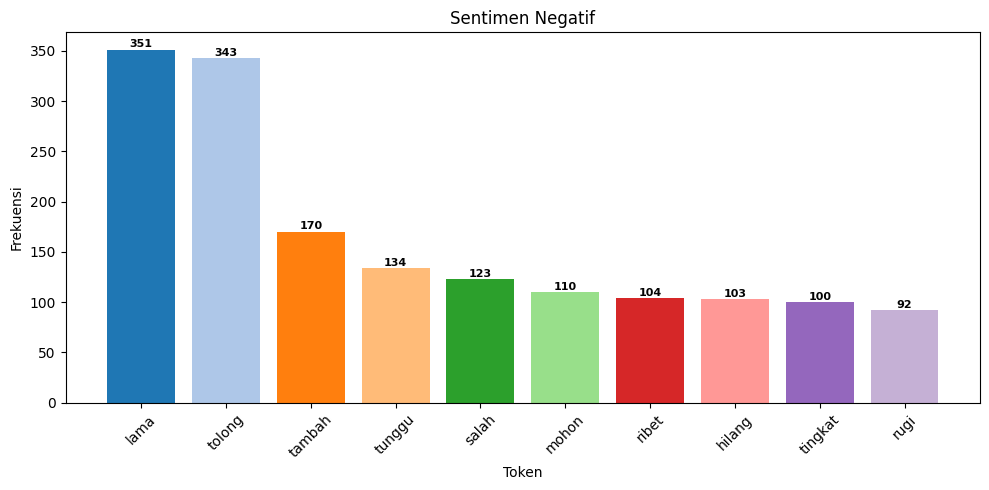

In [ ]:
# Sentimem kata negatif
import matplotlib.pyplot as plt
from collections import Counter

df = pd.read_csv('/content/svm 26 april/hasil pelabelan.csv')
lexicon = pd.read_csv('kamus lexicon pintu.csv')
lexicon_dict = dict(zip(lexicon['token'], lexicon['sentiment']))

# Hitung frekuensi token yang ada di stemming_text
token_counter = Counter()
for row in df['stemming_text'].dropna():
    tokens = row.split()
    for token in tokens:
        token_counter[token] += 1

# Kelompokkan token ke dalam kategori sentimen dari lexicon
pos_tokens = {}
neg_tokens = {}
netral_tokens = {}

for token, freq in token_counter.items():
    if token in lexicon_dict:
        score = lexicon_dict[token]
        if score > 0:
            pos_tokens[token] = freq
        elif score < 0:
            neg_tokens[token] = freq
        else:
            netral_tokens[token] = freq

# Ambil 10 token dengan frekuensi tertinggi dari masing-masing sentimen
top_neg = dict(Counter(neg_tokens).most_common(10))

# Fungsi untuk membuat warna acak
def get_random_colors(n):
    colors = plt.cm.tab20.colors  # palet warna yang bervariasi
    return [colors[i % len(colors)] for i in range(n)]

# Fungsi visualisasi diagram batang berwarna-warni dengan label angka
def plot_bar(data_dict, title):
    tokens = list(data_dict.keys())
    freqs = list(data_dict.values())
    colors = get_random_colors(len(tokens))

    plt.figure(figsize=(10, 5))
    bars = plt.bar(tokens, freqs, color=colors)
    plt.title(f'Sentimen {title}')
    plt.xlabel('Token')
    plt.ylabel('Frekuensi')
    plt.xticks(rotation=45)

    # Tambahkan label angka di atas setiap batang
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.5,
            str(int(height)),
            ha='center',
            va='bottom',
            fontsize=8,
            fontweight='semibold',
            color='#030303'
        )

    plt.tight_layout()
    plt.show()

# Panggil fungsi
plot_bar(top_neg, 'Negatif')

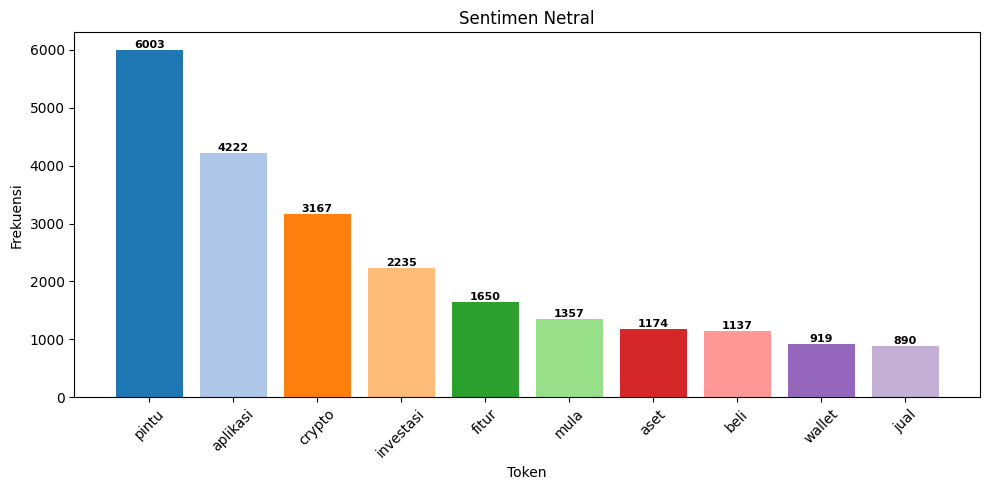

In [ ]:
# Sentimem kata netral
import matplotlib.pyplot as plt
from collections import Counter

df = pd.read_csv('/content/svm 26 april/hasil pelabelan.csv')
lexicon = pd.read_csv('kamus lexicon pintu.csv')
lexicon_dict = dict(zip(lexicon['token'], lexicon['sentiment']))

# Hitung frekuensi token yang ada di stemming_text
token_counter = Counter()
for row in df['stemming_text'].dropna():
    tokens = row.split()
    for token in tokens:
        token_counter[token] += 1

# Kelompokkan token ke dalam kategori sentimen dari lexicon
pos_tokens = {}
neg_tokens = {}
netral_tokens = {}

for token, freq in token_counter.items():
    if token in lexicon_dict:
        score = lexicon_dict[token]
        if score > 0:
            pos_tokens[token] = freq
        elif score < 0:
            neg_tokens[token] = freq
        else:
            netral_tokens[token] = freq

# Ambil 10 token dengan frekuensi tertinggi dari masing-masing sentimen
top_netral = dict(Counter(netral_tokens).most_common(10))

# Fungsi untuk membuat warna acak
def get_random_colors(n):
    colors = plt.cm.tab20.colors  # palet warna yang bervariasi
    return [colors[i % len(colors)] for i in range(n)]

# Fungsi visualisasi diagram batang berwarna-warni dengan label angka
def plot_bar(data_dict, title):
    tokens = list(data_dict.keys())
    freqs = list(data_dict.values())
    colors = get_random_colors(len(tokens))

    plt.figure(figsize=(10, 5))
    bars = plt.bar(tokens, freqs, color=colors)
    plt.title(f'Sentimen {title}')
    plt.xlabel('Token')
    plt.ylabel('Frekuensi')
    plt.xticks(rotation=45)

    # Tambahkan label angka di atas setiap batang
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.5,
            str(int(height)),
            ha='center',
            va='bottom',
            fontsize=8,
            fontweight='semibold',
            color='#030303'
        )

    plt.tight_layout()
    plt.show()

# Panggil fungsi
plot_bar(top_netral, 'Netral')

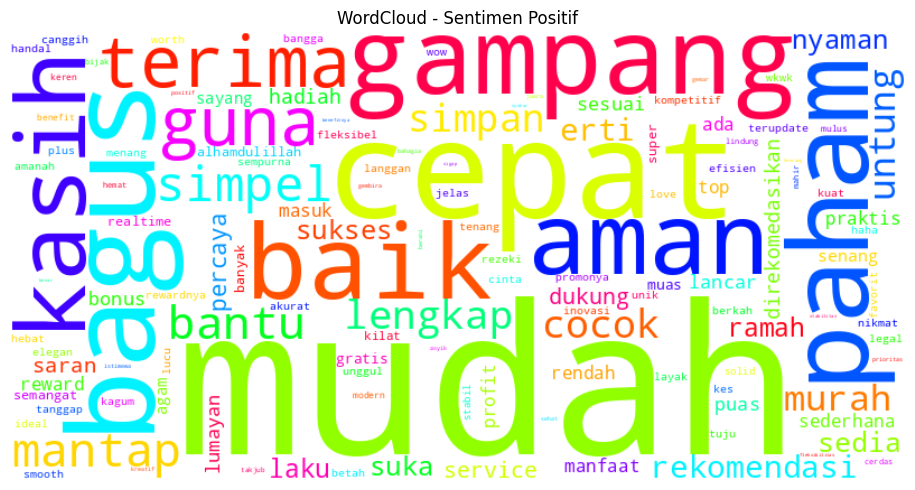

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random

# Fungsi untuk menghasilkan warna acak
def random_color_func(*args, **kwargs):
    return "hsl({}, 100%, 50%)".format(random.randint(0, 360))

# Buat WordCloud dari dictionary frekuensi langsung
wordcloud_pos = WordCloud(width=800, height=400,
                          background_color='white',
                          color_func=random_color_func).generate_from_frequencies(pos_tokens)

# Tampilkan WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Sentimen Positif')
plt.tight_layout()
plt.show()

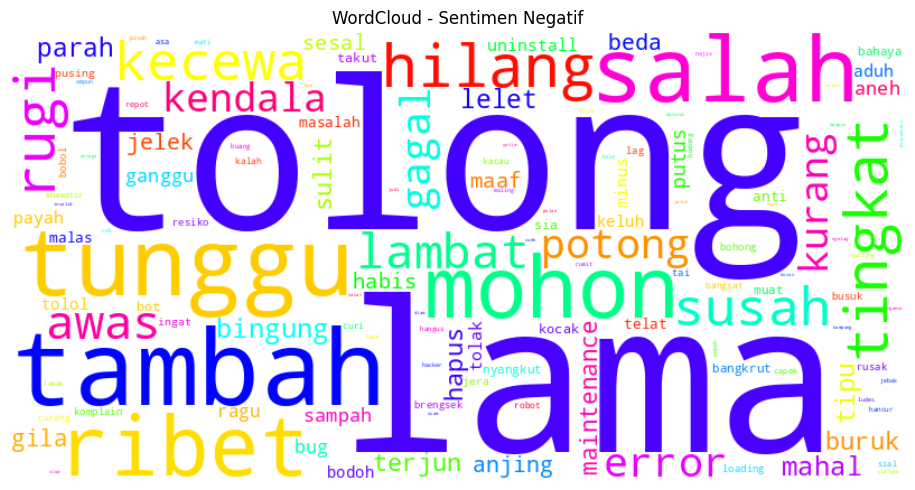

In [ ]:
# WordCloud untuk token negatif
wordcloud_neg = WordCloud(width=800, height=400,
                          background_color='white',
                          color_func=random_color_func).generate_from_frequencies(neg_tokens)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Sentimen Negatif')
plt.tight_layout()
plt.show()

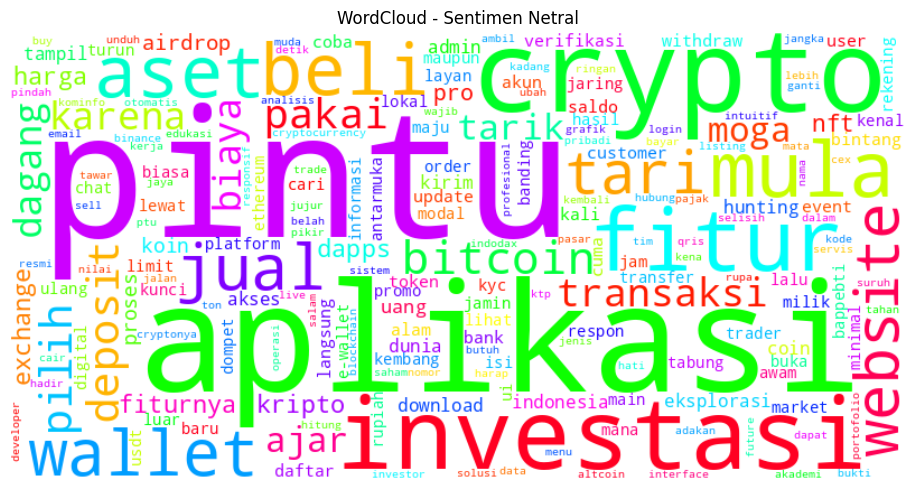

In [ ]:
# WordCloud untuk token netral
wordcloud_netral = WordCloud(width=800, height=400,
                             background_color='white',
                             color_func=random_color_func).generate_from_frequencies(netral_tokens)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_netral, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Sentimen Netral')
plt.tight_layout()
plt.show()